# **MÓDULO 39 - Exercicio - Aplicando XGboost**

Nessa atividade vocês usarão uma base já connhecida, a base de propensão a compra de carros.
Já utilizamos essa base antes, nessa atividade, você deve carregar a base, realizar os tratamentos necessários, rodar o XGBoost, encontrar as principais variaveis.
Vamos lá!

In [1]:
# Importação das bibliotecas

import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# 1. Carrega a base de dados, verifique os tipos de dados, dados faltantes e drop a coluna ID.


In [18]:
# Baixar a base, excluir a coluna 'ID' e visualizar o cabeçalho

base = pd.read_csv('/content/CARRO_CLIENTES.csv', delimiter=',')
base = base.drop(columns=['User ID'])
base.head(5)

,Gender,Age,AnnualSalary,Purchased
0,Male,35,20000,0
1,Male,40,43500,0
2,Male,49,74000,0
3,Male,40,107500,1
4,Male,25,79000,0


In [19]:
# Verificar os tipos de dados e a possibilidade de dados faltantes ou nulos

base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Gender        1000 non-null   object
 1   Age           1000 non-null   int64 
 2   AnnualSalary  1000 non-null   int64 
 3   Purchased     1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


# 2. Aplique o Label Encoder para a coluna Gender e exclua a coluna categórica.

In [44]:
# Aplicar Label Encoding na coluna 'Gender'
label_encoder = LabelEncoder()
base['Gender'] = label_encoder.fit_transform(base['Gender'])

# Visualizar o resultado
base.head(5)

,Gender,Age,AnnualSalary,Purchased
0,1,35,20000,0
1,1,40,43500,0
2,1,49,74000,0
3,1,40,107500,1
4,1,25,79000,0


# 3. Faça a matriz de correlação e analise as váriaveis que parecem ter maior correlação com a váriavel target.

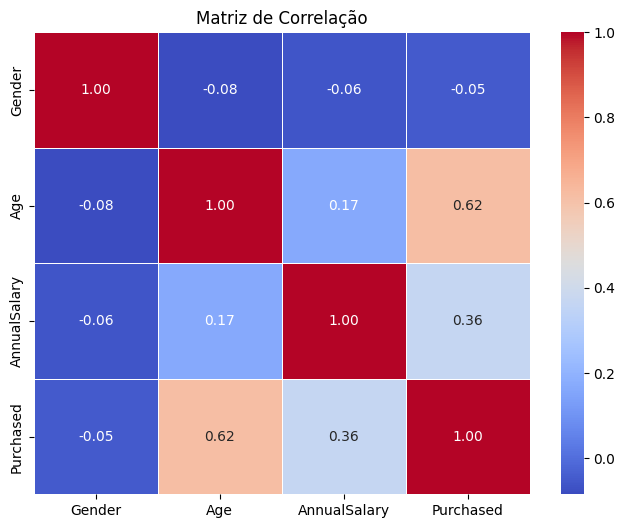

In [45]:
# Calcular a matriz de correlação
matriz_correlação = base.corr(numeric_only=True)

# Visualizar a matriz de correlação usando um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlação, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

Inicialmente, o fator de compra é principalmente influenciado pela idade, sem considerar uma análise de senioridade e juventude. Enquanto o salário anual do cliente possui certa relevância na compra, mas o que pouco influência, é o gênero do cliente, que possui baixa correlação com as outras categorias.

# 4. Faça a separação da base em X e Y e em seguida nas bases de treino e teste.

In [46]:
# Separando a variável dependente Y e as variáveis independentes X
X = base.drop(columns=['Purchased'])
Y = base['Purchased']

# Treinando o modelo
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 5. Treino o modelo Xgboost com sua base de treino.
Pesquise alguns hyperparametros na bibllioteca para utilizar, utilize ao menos 2.

In [47]:
# Treinando o modelo com dois hiperparâmetros novos
# learning_rate para tornar mais robusto a overfitting
# colsample_bytree para controlar as colunas usadas no treinamento, devido ao tamanho da base
model_xgboost = xgb.XGBClassifier(
    max_depth=6,
    n_estimators=100,
    learning_rate=0.3,      # valor padrão da documentação
    colsample_bytree=1,   # valor padrão da documentação
)
model_xgboost.fit(X_train, Y_train)
model_xgboost.objective

'binary:logistic'

# 6. Realize as previsões para a base de teste e traga as probabilidades das previsões.

In [48]:
# Realizando as previsões
Y_pred = model_xgboost.predict(X_test)           # Previsões das classes
Y_pred_prob = model_xgboost.predict_proba(X_test)  # Probabilidades de cada classe

# Exibir as primeiras 5 linhas das probabilidades
Y_pred_prob[:5]

array([[9.26876783e-01, 7.31231868e-02],
       [9.71430540e-02, 9.02856946e-01],
       [9.99860227e-01, 1.39749827e-04],
       [8.85204434e-01, 1.14795595e-01],
       [3.17659318e-01, 6.82340682e-01]], dtype=float32)

# 7. Faça a transformação das probabilidades nas previsões binárias e avalie o desempenho do modelo.

In [53]:
# Transformação das previsões e os rótulos de volta para os rótulos originais
Y_pred_original = label_encoder.inverse_transform(Y_pred)
Y_test_original = label_encoder.inverse_transform(Y_test)

# Calcular a acurácia
accuracy = accuracy_score(Y_test_original, Y_pred_original)
report = classification_report(Y_test_original, Y_pred_original)
conf_matrix = confusion_matrix(Y_test_original, Y_pred_original)

print(f'Acurácia: {accuracy}')
print(report)

Acurácia: 0.9
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       112
           1       0.90      0.86      0.88        88

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



 # Avaliando o modelo:

 - Acurácia: 90% - O modelo teve um excelente resultado para a amostra.

- O modelo é ligeiramente melhor em prever quando não comprou (classe 0), devido ao seu recall mais alto. Mas trazendo um f1-score alto em ambas as classes, traduzindo que no momento de previsão, ele está correto em grande parte (0 - 91% e 1 - 88%).

# 8. Traga a lista com a feature importance.
As features mais importantes são as mesmas que indicaram maior correlação na matriz de correlação?

In [54]:
importances = model_xgboost.get_booster().get_score(importance_type='gain')

# Convertendo o dicionário de importâncias para um DataFrame
importance_df = pd.DataFrame(list(importances.items()), columns=['Feature', 'Importance'])
importance_df['Importance'] = importance_df['Importance'].astype(float)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

        Feature  Importance
1           Age    1.851948
2  AnnualSalary    1.107248
0        Gender    0.496729


# Features X Matriz de correlação

Sim, as features mais importantes para o modelo são as mesmas indicadas no gráfico de correlação, incluindo a ordem de importância, com a idade impactando em ambos os resultados.